In [1]:
from z3 import *
import numpy as np
import re
import arviz as az

import os, sys
sys.path.append(os.path.join("../../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

# MCMC with SAT Sampler as Proposal Distribution

In this notebook, we show how to use the SAT sampler `spur` to generate proposal samples for the Metropolis-Hastings algorithm.

## Model definition (in Z3)

We start by defining the model in Z3. It must be an SMT model using bit-vectors (BitVec). Instead of using a Z3 `Solver` object, we must use a `Goal` object. This is needed to later bit-blast automatically the SMT problem.

In [2]:
# Assumption, all bit-vectors are of the same size
## NOTE: It looks like we need to always have one extra bit? For the sign?
num_bits = 4
num_vars = 3
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2]])) # important
g.add(ULE(0,x[0]))
g.add(ULE(x[0],3))
g.add(ULE(0,x[1]))
g.add(ULE(x[1],3))
g.add(ULE(0,x[2]))
g.add(ULE(x[2],6))
g.add(x[0] + x[1]  == x[2])

In [3]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=30000,
                                           num_chains=4)

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 30000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fo

c Number of samples found until now:  17420
c Number of samples found until now:  17430
c Number of samples found until now:  17440
c Number of samples found until now:  17450
c Number of samples found until now:  17460
c Number of samples found until now:  17470
c Number of samples found until now:  17480
c Number of samples found until now:  17490
c Number of samples found until now:  17500
c Number of samples found until now:  17510
c Number of samples found until now:  17520
c Number of samples found until now:  17530
c Number of samples found until now:  17540
c Number of samples found until now:  17550
c Number of samples found until now:  17560
c Number of samples found until now:  17570
c Number of samples found until now:  17580
c Number of samples found until now:  17590
c Number of samples found until now:  17600
c Number of samples found until now:  17610
c Number of samples found until now:  17620
c Number of samples found until now:  17630
c Number of samples found until 

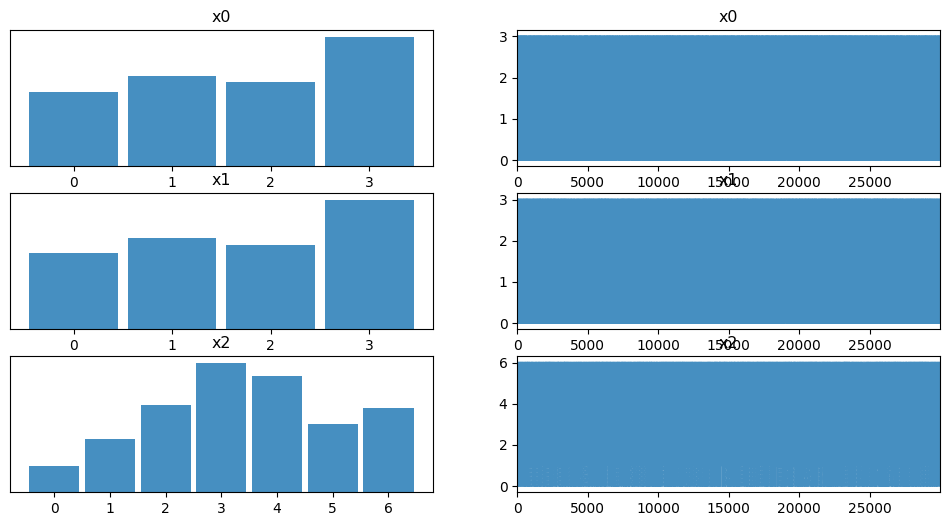

In [4]:
# Trace plot
import matplotlib.pyplot as plt
az.plot_trace(trace);
plt.savefig('cmsgen_triangle_trace_plot.png',dpi=150);

In [5]:
# Diagnosis
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1.711,1.132,0.0,3.0,0.003,0.002,118661.0,119651.0,1.0
x1,1.703,1.136,0.0,3.0,0.003,0.002,119043.0,119333.0,1.0
x2,3.413,1.677,1.0,6.0,0.005,0.003,118474.0,119143.0,1.0


In [6]:
utils.save_trace(trace, f'triangle_SAT_cmsgen_{num_vars}_{num_bits}.nc')

In [7]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist()) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist()) for i in range(0,7)])

[(0, 0.19616666666666666), (1, 0.23883333333333334), (2, 0.22313333333333332), (3, 0.34186666666666665)]
[(0, 0.04636666666666667), (1, 0.0944), (2, 0.15433333333333332), (3, 0.2291), (4, 0.20553333333333335), (5, 0.12083333333333333), (6, 0.14943333333333333)]


## Non-uniform prior

Here we use the `f` parameter of our MH function to specify a prior for the variables of the SMT problem.

In particular, we consider the following very simple model

$$
x_0 \sim \mathit{Cat}(1/3, 1/3, 1/6, 1/6) ~~
x_1 \sim \mathit{U}(0,3) ~~
x_2 = x_0 + x_1
$$


In [8]:
def prior(s: dict[str, int]):
    x0 = s['x0']
    x1 = s['x1']
    p_x0 = 1/3 if x0 < 2 else 1/6
    p_x1 = 1/4

    return p_x0 * p_x1

def likelihood(s: dict[str, int]):
    return 1

In [9]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=30000,
                                           num_chains=4,
                                           f= lambda s: prior(s)*likelihood(s))

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 30000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fo

c Number of samples found until now:   6300
c Number of samples found until now:   6310
c Number of samples found until now:   6320
c Number of samples found until now:   6330
c Number of samples found until now:   6340
c Number of samples found until now:   6350
c Number of samples found until now:   6360
c Number of samples found until now:   6370
c Number of samples found until now:   6380
c Number of samples found until now:   6390
c Number of samples found until now:   6400
c Number of samples found until now:   6410
c Number of samples found until now:   6420
c Number of samples found until now:   6430
c Number of samples found until now:   6440
c Number of samples found until now:   6450
c Number of samples found until now:   6460
c Number of samples found until now:   6470
c Number of samples found until now:   6480
c Number of samples found until now:   6490
c Number of samples found until now:   6500
c Number of samples found until now:   6510
c Number of samples found until 

c Number of samples found until now:  14840
c Number of samples found until now:  14850
c Number of samples found until now:  14860
c Number of samples found until now:  14870
c Number of samples found until now:  14880
c Number of samples found until now:  14890
c Number of samples found until now:  14900
c Number of samples found until now:  14910
c Number of samples found until now:  14920
c Number of samples found until now:  14930
c Number of samples found until now:  14940
c Number of samples found until now:  14950
c Number of samples found until now:  14960
c Number of samples found until now:  14970
c Number of samples found until now:  14980
c Number of samples found until now:  14990
c Number of samples found until now:  15000
c Number of samples found until now:  15010
c Number of samples found until now:  15020
c Number of samples found until now:  15030
c Number of samples found until now:  15040
c Number of samples found until now:  15050
c Number of samples found until 

c Number of samples found until now:  21240
c Number of samples found until now:  21250
c Number of samples found until now:  21260
c Number of samples found until now:  21270
c Number of samples found until now:  21280
c Number of samples found until now:  21290
c Number of samples found until now:  21300
c Number of samples found until now:  21310
c Number of samples found until now:  21320
c Number of samples found until now:  21330
c Number of samples found until now:  21340
c Number of samples found until now:  21350
c Number of samples found until now:  21360
c Number of samples found until now:  21370
c Number of samples found until now:  21380
c Number of samples found until now:  21390
c Number of samples found until now:  21400
c Number of samples found until now:  21410
c Number of samples found until now:  21420
c Number of samples found until now:  21430
c Number of samples found until now:  21440
c Number of samples found until now:  21450
c Number of samples found until 

c Number of samples found until now:  29080
c Number of samples found until now:  29090
c Number of samples found until now:  29100
c Number of samples found until now:  29110
c Number of samples found until now:  29120
c Number of samples found until now:  29130
c Number of samples found until now:  29140
c Number of samples found until now:  29150
c Number of samples found until now:  29160
c Number of samples found until now:  29170
c Number of samples found until now:  29180
c Number of samples found until now:  29190
c Number of samples found until now:  29200
c Number of samples found until now:  29210
c Number of samples found until now:  29220
c Number of samples found until now:  29230
c Number of samples found until now:  29240
c Number of samples found until now:  29250
c Number of samples found until now:  29260
c Number of samples found until now:  29270
c Number of samples found until now:  29280
c Number of samples found until now:  29290
c Number of samples found until 

### Posterior analysis

We observe the in the traceplot below the effect of the prior on $x_0$. Now it is distributed as according to the categorical distribution above. As opposed to the uniform prior we used in the previous analysis.

The distribution of $x_2$ is also affected by the new prior on $x_0$.

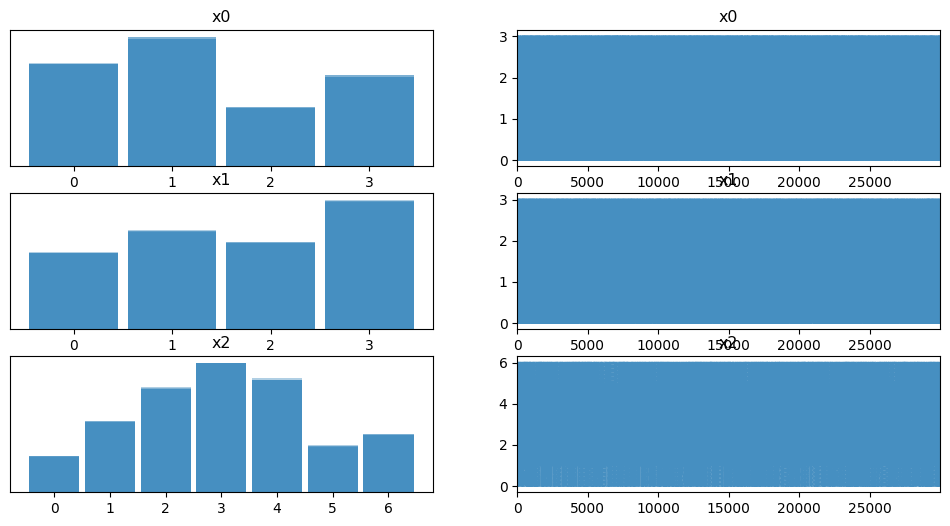

In [10]:
az.plot_trace(trace);
plt.savefig('cmsgen_trace_plot_non_uniform.png',dpi=150);

Here we plot the probability of each outcome for $x_0$ and $x_2$. Note that due to the lack of uniformity in sampling, the posterior is a bit imprecise. For instance, in x0 we should expect the probability of 3 to be lower.

In [11]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist()) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist()) for i in range(0,7)])

[(0, 0.27036666666666664), (1, 0.3379916666666667), (2, 0.154275), (3, 0.23736666666666667)]
[(0, 0.06499166666666667), (1, 0.126675), (2, 0.18720833333333334), (3, 0.23189166666666666), (4, 0.20269166666666666), (5, 0.083), (6, 0.10354166666666667)]


Finally, we compare the estimated values with the analytical solution to this problem.

In [12]:
real_value_x0 = [1/3, 1/3, 1/6, 1/6]
real_value_x2 = [1/12, 1/6, 5/24, 1/4, 1/6, 1/12, 1/24]

In [13]:
print([(i, (trace.posterior['x0'] == i).mean().values.tolist() - real_value_x0[i]) for i in range(0,4)])
print([(i, (trace.posterior['x2'] == i).mean().values.tolist() - real_value_x2[i]) for i in range(0,7)])

[(0, -0.06296666666666667), (1, 0.004658333333333375), (2, -0.012391666666666662), (3, 0.07070000000000001)]
[(0, -0.01834166666666666), (1, -0.03999166666666665), (2, -0.021125000000000005), (3, -0.018108333333333337), (4, 0.036025), (5, -0.0003333333333333244), (6, 0.061875000000000006)]


The error is low ($< 0.08$ for x0 and $< 0.07$ for x2 for all outcomes). However, I should remark that in other executions I observed errors up to 0.13...

In [14]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,1.359,1.116,0.0,3.0,0.004,0.003,69380.0,67425.0,1.0
x1,1.685,1.126,0.0,3.0,0.004,0.003,81754.0,78724.0,1.0
x2,3.044,1.656,0.0,6.0,0.006,0.004,75138.0,66350.0,1.0


In [15]:
utils.save_trace(trace, f'triangle_prior_SAT_cmsgen_{num_vars}_{num_bits}.nc')